# import

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/2023-1/졸업논문/baseline

/content/drive/MyDrive/Colab Notebooks/2023-1/졸업논문/baseline


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline'

In [ ]:
!pip install fmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result, download_test_file
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

import random
import numpy as np
import torch
import argparse
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras

from collections import deque
import numpy as np
from tqdm import tqdm

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import scipy.signal
import time

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch import FloatTensor as FT

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

# Environment

In [ ]:
fmu_filename = 'HEV_TMED_Simulator_Rearrange_230213_linux.fmu'
start_time = 0.0
stop_time = 1800.0
step_size = 0.01
soc_init = 67

# WLTP profile에 대하여 시험
with open("wltp_vehicle_speed_profile_real.csv") as file_name:
    vehicle_speed_profile = np.loadtxt(file_name, delimiter=",")

In [ ]:
class HEV:
    def __init__(self, fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile):
        self.fmu_filename = fmu_filename
        self.vrs = {}
        self.start_time = start_time
        self.stop_time = stop_time
        self.step_size = step_size
        self.time = self.start_time
        self.vehicle_speed_profile = vehicle_speed_profile
        self.soc_init = soc_init
        self.state = np.array([self.soc_init, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1,-1)
        self.action_upper_bound = 15000
        self.action_lower_bound = -15000
        #self.action_space = [[13500, 2000], [500, 2000], [13500, -15000], [500, -15000]]
        self.obssize = len(self.state[0])
        self.actsize = 1
        
    def step(self, action):
        #a = self.action_space[action]
        action = action*self.action_upper_bound
        a1 = action
        a2 = action
        instant_veh_speed = np.interp(self.time, self.vehicle_speed_profile[:,0], self.vehicle_speed_profile[:,1])
        self.fmu.setReal([self.vr_input1, self.vr_input2, self.vr_input3], [instant_veh_speed, a1, a2]) #input variable, input key(13500 2000)
        self.fmu.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
#         [output1, output2, output3, output4, output5, output6, output7] = self.fmu.getReal([self.vr_output1,self.vr_output2, self.vr_output3, self.vr_output4, self.vr_output5, self.vr_output6, self.vr_output7])
#         self.state = [output1, output2, output3, output4, output5, output6, output7]
        state = self.fmu.getReal(np.arange(30))
        state_column = np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])
        self.state = np.array(state)[state_column]
        soc = state[self.vrs['Bat_SOC']]
        BSFC = state[self.vrs['BSFC_g_kWh[1]']]
        reward = - 0.1*(self.soc_init - soc) ** 2 - BSFC
        is_done = lambda time: time >= self.stop_time
        self.time += self.step_size
        return self.state.reshape(1,-1), reward, is_done(self.time), None
    
    def reset(self):
        model_description = read_model_description(self.fmu_filename)
        for variable in model_description.modelVariables:
            self.vrs[variable.name] = variable.valueReference
        unzipdir = extract(fmu_filename)
        self.fmu = FMU2Slave(guid=model_description.guid,
                       unzipDirectory=unzipdir,
                       modelIdentifier=model_description.coSimulation.modelIdentifier,
                       instanceName='instance1')
        self.fmu.instantiate()
        self.fmu.setupExperiment(startTime=self.start_time)
        self.fmu.enterInitializationMode()
        self.fmu.exitInitializationMode()
        self.time = self.start_time
        
        self.vr_input1 = self.vrs['Driver_sVeh_Target_kph']
        self.vr_input2 = self.vrs['Engine_on_line']
        self.vr_input3 = self.vrs['Engine_off_line']
        self.vr_output1 = self.vrs['TgMod_fPt']
        self.vr_output2 = self.vrs['P2_wElec_W']
        self.vr_output3 = self.vrs['P4_wElec_W']
        self.vr_output4 = self.vrs['ObP2_wElecBIntv_W']
        self.vr_output5 = self.vrs['EV_on_line']
        self.vr_output6 = self.vrs['EV_off_line']
        self.vr_output7 = self.vrs['Bat_SOC']
        self.vr_output8 = self.vrs['PT_tqTmInDmd_Nm_P2']
        self.vr_output9 = self.vrs['P0_wElec_W']
        self.vr_output10 = self.vrs['Pwr_Aux_W']
        self.vr_output11 = self.vrs['ObEng_nEng_Rpm']
        self.vr_output12 = self.vrs['TrEtp_tqEngMAF_Nm']
        self.vr_output13 = self.vrs['rpm_P0']
        self.vr_output14 = self.vrs['TM_F_nTmIn_rpm']
        self.vr_output15 = self.vrs['TM_R_nTmIn_rpm']
        self.vr_output16 = self.vrs['eBat_kWh']
        self.vr_output17 = self.vrs['nEngOn']
        self.vr_output18 = self.vrs['TrP0_tqP0_Nm']
        self.vr_output19 = self.vrs['TrP2_tqP2_Nm']
        self.vr_output20 = self.vrs['TrP4_tqP4_Nm']
        self.vr_output21 = self.vrs['TCU_F_fCurGe']
        self.vr_output22 = self.vrs['TCU_F_fTarGe']
        self.vr_output23 = self.vrs['Driver_sVeh_kph']
        self.vr_output24 = self.vrs['Eng_eff_avg']
        self.vr_output25 = self.vrs['TM_F_P0P2_eff_avg']
        self.vr_output26 = self.vrs['TM_F_P0P4_eff_avg']
        self.vr_output27 = self.vrs['BSFC_g_kWh[1]']
        self.vr_output28 = self.vrs['BSFC_g_kWh[2]']
        self.vr_output29 = self.vrs['BSFC_g_kWh[3]']
        
        return self.state.reshape(1,-1)

# Test

In [ ]:
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
env.reset()
action = np.array([1])
s, r, d, _ = env.step(action)
r

-4.1000932710341396e-10

In [ ]:
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
env.reset()

done = False
cum_reward = 0.0
action = np.array([1])
start = time.time()
r_record = []
while not done:    
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    r_record.append(reward)

print(time.time()-start)
print(f"total reward: {cum_reward}") #-32914681.284981396

14.955002307891846
total reward: -32914681.284981396


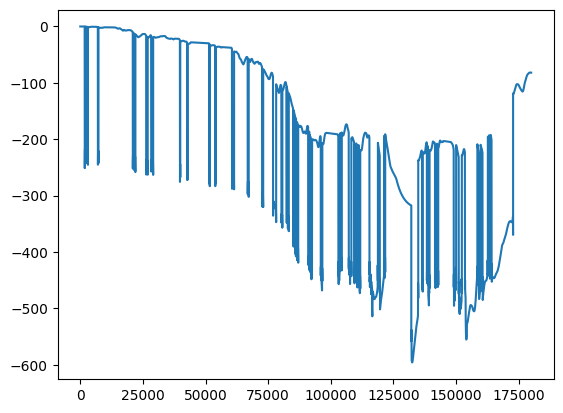

In [ ]:
plt.plot(r_record)